# Clustering of drawn components in galaxy builder

### Problem:

*Given a set of ellipses and rotated rectangles (in zooniverse coordinates), how do we recover one aggregate shape for each task?*

First, say the jupyter magic words 🧙‍

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import the plethora of useful modules we'll need (including some we probably don't)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN
from panoptes_aggregation.reducers.shape_metric import avg_angle
import lib.galaxy_utilities as gu
import wrangle_classifications as wc

Which subject should we work on? (parametrised to allow batch running at a later date)

In [3]:
subject_id = 20902086 # 20902064

Implement a temporary way of reading in data till the zooniverse CSV export is fixed:

In [4]:
with open('tmp_cls_dump.json') as f:
    classifications = json.load(f)
classifications_for_subject = [
    c for c in classifications
    if c['links']['subjects'][0] == str(subject_id)
]
print('Found {} classifications for subject_id {}'.format(
    len(classifications_for_subject),
    subject_id,
))
annotations_for_subject = [i['annotations'] for i in classifications_for_subject]

Found 52 classifications for subject_id 20902086


Grab the galaxy data (and classification data) for this galaxy

In [5]:
print('Getting galaxy data')
gal, angle = gu.get_galaxy_and_angle(subject_id)
url = gu.getUrl(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
# classifications = gu.classifications
# classifications_for_subject = classifications['subject_ids'] == subject_id
# annotations_for_subject = [
#     eval(foo) for foo in
#     classifications_for_subject
# ]

Getting galaxy data


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


As we might want to do some model rendering later, we'll grab the galaxy's PSF (from the data used in online model rendering)

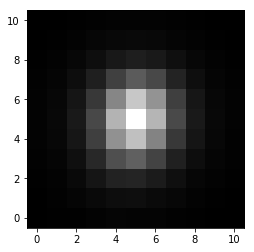

In [33]:
psf = gu.get_psf(subject_id)
_ = plt.imshow(psf, origin='lower', cmap='gray')

Grab the difference JSON data for this subject (used later for rendering)

In [7]:
diff_data = gu.get_image_data(subject_id)

Iterate through the annotations and grab the classifications for disks, bulges and bars:

In [8]:
disks = [a[0] for a in annotations_for_subject if len(a) == 4]
bulges = [a[1] for a in annotations_for_subject if len(a) == 4]
bars = [a[2] for a in annotations_for_subject if len(a) == 4]

Filter those down to only the annotations where a volunteer has drawn something

In [9]:
drawn_disks = [i for i in disks if len(i['value'][0]['value']) > 0]
drawn_bulges = [i for i in bulges if len(i['value'][0]['value']) > 0]
drawn_bars = [i for i in bars if len(i['value'][0]['value']) > 0]

Make use of some handy functions in `wrangle_classifications` to convert these annotations to [`Shapely`](https://shapely.readthedocs.io/en/stable/) geometries

In [10]:
disk_geoms = np.array([
    wc.ellipse_geom_from_zoo(d['value'][0]['value'][0])
    for d in drawn_disks
])
bulge_geoms = np.array([
    wc.ellipse_geom_from_zoo(b['value'][0]['value'][0])
    for b in drawn_bulges
])
bar_geoms = np.array([
    wc.bar_geom_from_zoo(b['value'][0]['value'][0])
    for b in drawn_bars
])

Let's have a look at what we're working with:

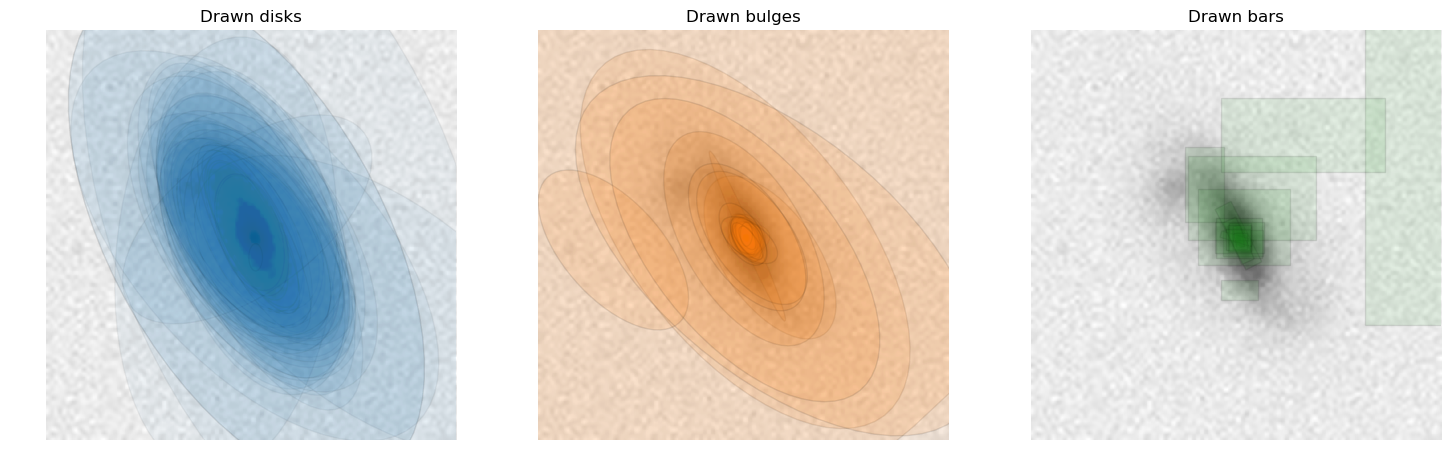

In [34]:
fig = plt.figure(1, figsize=(18, 6), dpi=100)

plt.subplot(131)
plt.imshow(pic_array, origin='lower', cmap='gray_r')

for patch in disk_geoms:
    p = PolygonPatch(patch, fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn disks'); plt.axis('off')

plt.subplot(132)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for patch in bulge_geoms:
    p = PolygonPatch(patch, fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn bulges'); plt.axis('off')

plt.subplot(133)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for patch in bar_geoms:
    p = PolygonPatch(patch, fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.title('Drawn bars')
_ = plt.axis('off')

# Clustering components:


Chosen metric is based on the *Jaccard similarity score*:

$$S = \frac{\text{intersection area}}{\text{union area}}$$

Instead we use the *Jaccard distance*

$$S = 1 - \frac{\text{intersection area}}{\text{union area}}$$

Calculate a pre-computed distance matrix for each component (not slow as we're using well-optimized `shapely` methods)

In [12]:
disk_distances = wc.gen_jaccard_distances(disk_geoms)
bulge_distances = wc.gen_jaccard_distances(bulge_geoms)
bar_distances = wc.gen_jaccard_distances(bar_geoms)

Define our clusterers (we'll use DBSCAN, though HDBSCAN might be a better alternative). Using one each as it allows tuning of the parameters for each component.

In [13]:
clf_disk = DBSCAN(eps=0.2, metric='precomputed')
clf_disk.fit(disk_distances)
disk_labels = clf_disk.labels_

clf_bulge = DBSCAN(eps=0.4, metric='precomputed')
clf_bulge.fit(bulge_distances)
bulge_labels = clf_bulge.labels_

clf_bar = DBSCAN(eps=0.4, metric='precomputed')
clf_bar.fit(bar_distances)
bar_labels = clf_bar.labels_

Our resulting clusters look like this: (empty sub-plot means no cluster)

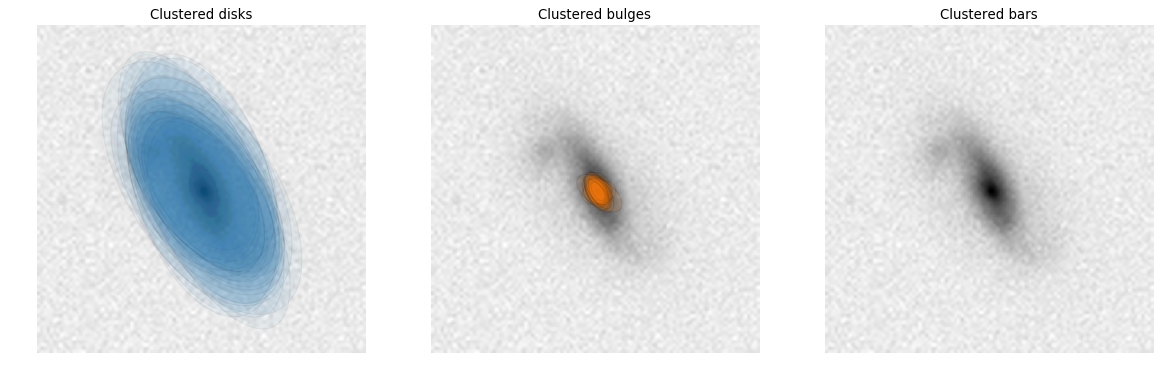

In [35]:
fig = plt.figure(1, figsize=(18, 6), dpi=80)
plt.subplot(131)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for disk in disk_geoms[disk_labels == 0]:
    p = PolygonPatch(disk, fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.axis('off')
plt.title('Clustered disks')

plt.subplot(132)
fig = plt.figure(1, figsize=(6, 6), dpi=100)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for bulge in bulge_geoms[bulge_labels == 0]:
    p = PolygonPatch(bulge, fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.axis('off')
plt.title('Clustered bulges')

plt.subplot(133)
fig = plt.figure(1, figsize=(6, 6), dpi=100)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for bar in bar_geoms[bar_labels == 0]:
    p = PolygonPatch(bar, fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
plt.axis('off')
_ = plt.title('Clustered bars')

Let's grab the original annotation data for these clustered shapes

In [15]:
clustered_disks = [d['value'][0]['value'][0] for d in np.array(drawn_disks)[disk_labels == 0]]
clustered_bulges = [b['value'][0]['value'][0] for b in np.array(drawn_bulges)[bulge_labels == 0]]
clustered_bars = [b['value'][0]['value'][0] for b in np.array(drawn_bars)[bar_labels == 0]]

## Mean component calculation

We'll calculate our aggregate component by calculating:
- the mean of the center points of each shape
- the mean of widths and heights of each shape
- the circular mean of the angle of each shape (performed using the zooniverse's `panoptes-aggregation` package)

{'angle': 58.726,
 'rx': 171.24364101992273,
 'ry': 87.28528410156146,
 'x': 258.13846687648606,
 'y': 254.83575373110563}


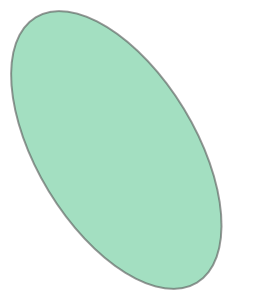

In [17]:
mean_disk = {}
mean_disk['x'] = np.mean([i['x'] for i in clustered_disks])
mean_disk['y'] = np.mean([i['y'] for i in clustered_disks])
mean_disk['rx'] = np.mean([max(i['rx'], i['ry']) for i in clustered_disks])
mean_disk['ry'] = np.mean([min(i['rx'], i['ry']) for i in clustered_disks])
disk_angles = [
    i['angle'] if i['rx'] > i['ry'] else (i['angle'] + 90)
    for i in clustered_disks
]
mean_disk['angle'] = avg_angle(disk_angles, factor=2)

mean_disk_geom = wc.ellipse_geom_from_zoo(mean_disk)
pprint(mean_disk)
mean_disk_geom

{'angle': 56.389,
 'rx': 24.162025381197115,
 'ry': 14.577070876311945,
 'x': 260.1018862516984,
 'y': 251.90087558912194}


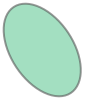

In [18]:
mean_bulge = {}
mean_bulge['x'] = np.mean([i['x'] for i in clustered_bulges])
mean_bulge['y'] = np.mean([i['y'] for i in clustered_bulges])
mean_bulge['rx'] = np.mean([max(i['rx'], i['ry']) for i in clustered_bulges])
mean_bulge['ry'] = np.mean([min(i['rx'], i['ry']) for i in clustered_bulges])
bulge_angles = [
    i['angle'] if i['rx'] > i['ry'] else (i['angle'] + 90)
    for i in clustered_bulges
]

mean_bulge['angle'] = avg_angle(bulge_angles, factor=2)

mean_bulge_geom = wc.ellipse_geom_from_zoo(mean_bulge)
pprint(mean_bulge)
mean_bulge_geom

In [19]:
center_xs = [i['x'] + i['width']/2 for i in clustered_bars]
center_ys = [i['y'] + i['height']/2 for i in clustered_bars]
mean_center = (np.mean(center_xs), np.mean(center_ys))

mean_bar = {}
mean_bar['width'] = np.mean([max(i['width'], i['height']) for i in clustered_bars])
mean_bar['height'] = np.mean([min(i['width'], i['height']) for i in clustered_bars])
mean_bar['x'] = mean_center[0] - mean_bar['width'] / 2
mean_bar['y'] = mean_center[1] - mean_bar['height'] / 2
bar_angles = [
    i['angle'] if i['width'] > i['height'] else (i['angle'] + 90)
    for i in clustered_bars
]
mean_bar['angle'] = avg_angle(bar_angles, factor=2)

mean_bar_geom = wc.bar_geom_from_zoo(mean_bar)
pprint(mean_bar)
mean_bar_geom

/Users/tlingard/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tlingard/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
IllegalArgumentException: Points of LinearRing do not form a closed linestring
Shell is not a LinearRing


ValueError: not enough values to unpack (expected 4, got 0)

If there's an error, it's because there was no cluster to aggregate!

Let's have a look at our resulting shapes relative to their clusters!

In [29]:
bulge_crop = 180
bar_crop = 140

In [36]:
print('Defining patches...')
mean_disk_patch = PolygonPatch(mean_disk_geom, fc='C1', ec='k', alpha=0.4, zorder=3)
try:
    mean_bulge_patch = PolygonPatch(mean_bulge_geom, fc='C2', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass
try:
    mean_bar_patch = PolygonPatch(mean_bar_geom, fc='C3', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass

Defining patches...


(140, 372)

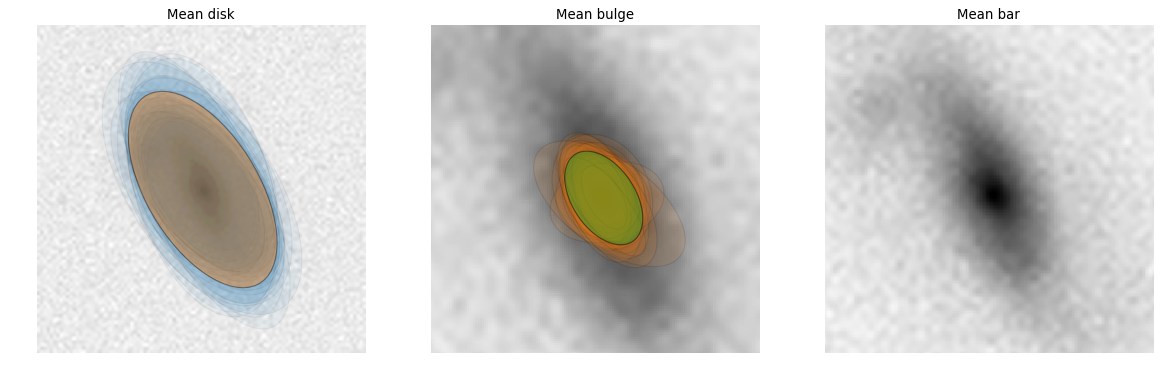

In [31]:
fig = plt.figure(1, figsize=(18, 6), dpi=80)
plt.subplot(131)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for disk in disk_geoms[disk_labels == 0]:
    p = PolygonPatch(disk, fc='C0', ec='k', alpha=0.05, zorder=2)
    plt.gca().add_patch(p)
plt.gca().add_patch(mean_disk_patch)
plt.axis('off')
plt.title('Mean disk')

plt.subplot(132)
fig = plt.figure(1, figsize=(6, 6), dpi=100)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for bulge in bulge_geoms[bulge_labels == 0]:
    p = PolygonPatch(bulge, fc='C1', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bulge_patch)
except NameError:
    pass
plt.axis('off')
plt.title('Mean bulge')
plt.xlim(bulge_crop, pic_array.shape[0] - bulge_crop);
plt.ylim(bulge_crop, pic_array.shape[0] - bulge_crop)

plt.subplot(133)
fig = plt.figure(1, figsize=(6, 6), dpi=100)
plt.imshow(pic_array, origin='lower', cmap='gray_r')
for bar in bar_geoms[bar_labels == 0]:
    p = PolygonPatch(bar, fc='C2', ec='k', alpha=0.1, zorder=2)
    plt.gca().add_patch(p)
try:
    plt.gca().add_patch(mean_bar_patch)
except NameError:
    pass
plt.axis('off')
plt.title('Mean bar')
plt.xlim(bar_crop, pic_array.shape[0] - bar_crop);
plt.ylim(bar_crop, pic_array.shape[0] - bar_crop)

And finally, let's see our resulting galaxy model

In [37]:
print('Defining patches...')
mean_disk_patch = PolygonPatch(mean_disk_geom, fc='C0', ec='k', alpha=0.2, zorder=3)
try:
    mean_bulge_patch = PolygonPatch(mean_bulge_geom, fc='C1', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass
try:
    mean_bar_patch = PolygonPatch(mean_bar_geom, fc='C2', ec='k', alpha=0.5, zorder=3)
except NameError:
    pass

Defining patches...


(-0.5, 511.5, -0.5, 511.5)

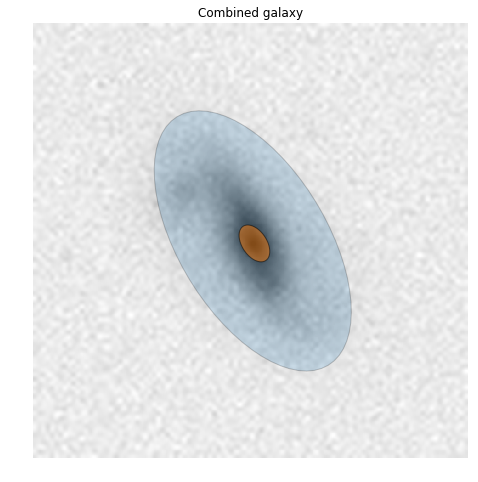

In [28]:
plt.figure(figsize=(8,8))
plt.title('Combined galaxy')
plt.imshow(pic_array, origin='lower', cmap='gray_r')
try:
    plt.gca().add_patch(mean_disk_patch)
except NameError:
    pass
try:
    plt.gca().add_patch(mean_bulge_patch)
except NameError:
    pass
try:
    plt.gca().add_patch(mean_bar_patch)
except NameError:
    pass
plt.axis('off')

And there we have it! A complex photometric model (sort of) fit to SDSS r-band data, performed using citizen science